### Project Part 1

In this project my goal is to measure the volatility spillover between equity markets around the world. The data I need will be the equity indices from all major financial markets (US, China, Japan, Hong Kong, Canada, UK, Germany). I will use the daily returns of these indeces to calculate the monthly volatility. I will use plots to visualize how the volatility changes over time to demonstrate the autoregressive heteroscedastic nature of volatility in financial markets. In Part 2 I will use a Vector Auto Regression (VAR) to measure how volatility "spills over" from country to country on a monthly level. The VAR will then be used to forecast volatility in markets. The VAR is also used to plot an impulse control function.

In [130]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from statsmodels.tsa.api import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
import keras


In [131]:



# Dictionary of major indices and their Yahoo Finance tickers
indices = {
    "S&P500_US": "^GSPC",
    "Shanghai_China": "000001.SS",
    "Nikkei_Japan": "^N225",
    "HangSeng_HK": "^HSI",
    "S&P_TSX_Canada": "^GSPTSE",
    "FTSE100_UK": "^FTSE",
    "DAX_Germany": "^GDAXI",
}

# Define date range
start_date = "2000-12-1"
end_date = "2025-01-01"

# Download data
all_data = pd.DataFrame()

# Loop through tickers
for name, ticker in indices.items():
    print(f"Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date)

    if data.empty or 'Close' not in data.columns:
        print(f"Warning: No Close data for {ticker}, skipping.")
        continue

    # Extract Close prices
    close_data = data['Close']

    # Ensure we have a DataFrame with the correct column name
    if isinstance(close_data, pd.Series):
        close_data = close_data.to_frame(name)
    elif isinstance(close_data, pd.DataFrame):
        close_data = close_data.rename(columns={'Close': name})

    # Combine with main DataFrame
    if all_data.empty:
        all_data = close_data
    else:
        all_data = all_data.join(close_data, how="outer")


#all_data.head()
all_data.tail()

C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\3731755312.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\3731755312.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\3731755312.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\3731755312.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\3731755312.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\3731755312.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tick

Ticker,^GSPC,000001.SS,^N225,^HSI,^GSPTSE,^FTSE,^GDAXI
Date,,,,,,,
2024-12-25,NaN,3393.350098,39130.429688,NaN,NaN,NaN,NaN
2024-12-26,6037.589844,3398.076904,39568.058594,NaN,NaN,NaN,NaN
2024-12-27,5970.839844,3400.142090,40281.160156,20090.460938,24796.400391,8149.799805,19984.320312
2024-12-30,5906.939941,3407.325928,39894.539062,20041.419922,24620.599609,8121.000000,19909.140625
2024-12-31,5881.629883,3351.762939,NaN,20059.949219,24727.900391,8173.000000,NaN


Countries have different hollydays so therefore removing NaN will leave me with too little data. I fill forward, this way when I calculate returns they will be zero on non trading days. This makes conceptual sense.

In [132]:
all_data = all_data.fillna(method = 'ffill')

C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\395193178.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data = all_data.fillna(method = 'ffill')


Check if there is still any missing data.

In [133]:
np.sum(all_data.isna(), axis = 0)


Ticker
^GSPC        0
000001.SS    0
^N225        0
^HSI         0
^GSPTSE      0
^FTSE        0
^GDAXI       0
dtype: int64

I calculate the log returns. Log returns are very close to the actual returns especially for small returns such as in daily returns. log returns are calculated as:  
$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

I plot the return to ilustrate the heteroscedaticity of volatility. Also known as volatility clustering.

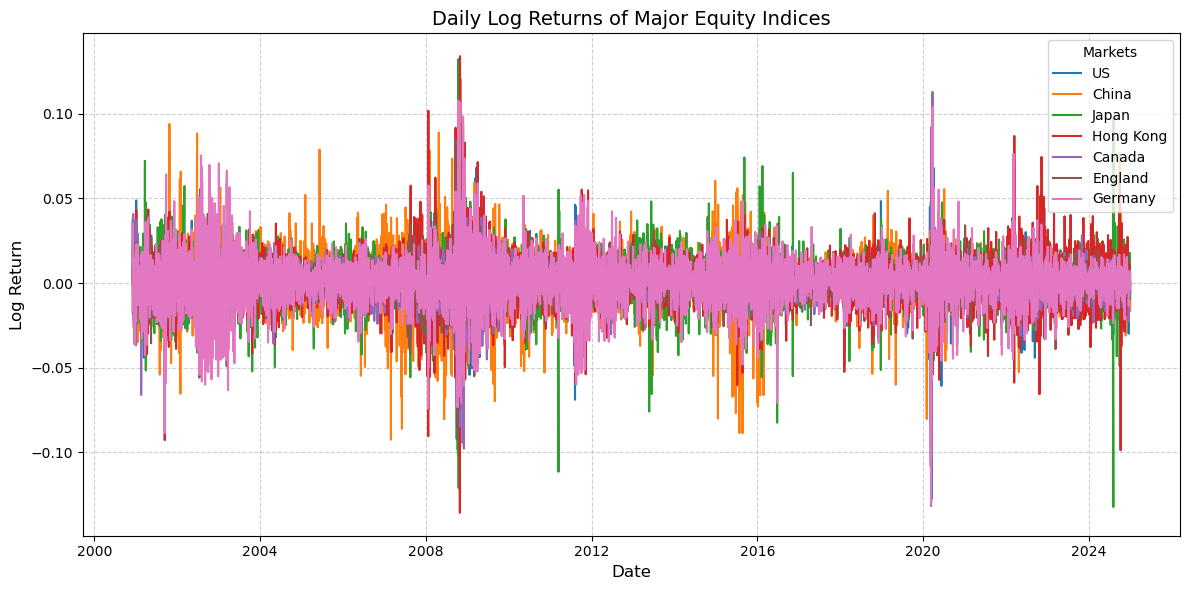

In [134]:
returns = np.log(all_data/all_data.shift(1))
returns = returns.iloc[1:,:]
returns.columns = ['US', 'China', 'Japan', 'Hong Kong', 'Canada', 'England', 'Germany']
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.title("Daily Log Returns of Major Equity Indices", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Log Return", fontsize=12)
plt.legend(returns.columns, title="Markets", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


We can kind of see that there is volatility clustering but it is unclear. Looking at the volatility itself will be more informative.

I use a correlation matrix to show the contemperanious correlations between indices. I replace the index tickers with country names to simplify and make the matrix easier to understand.

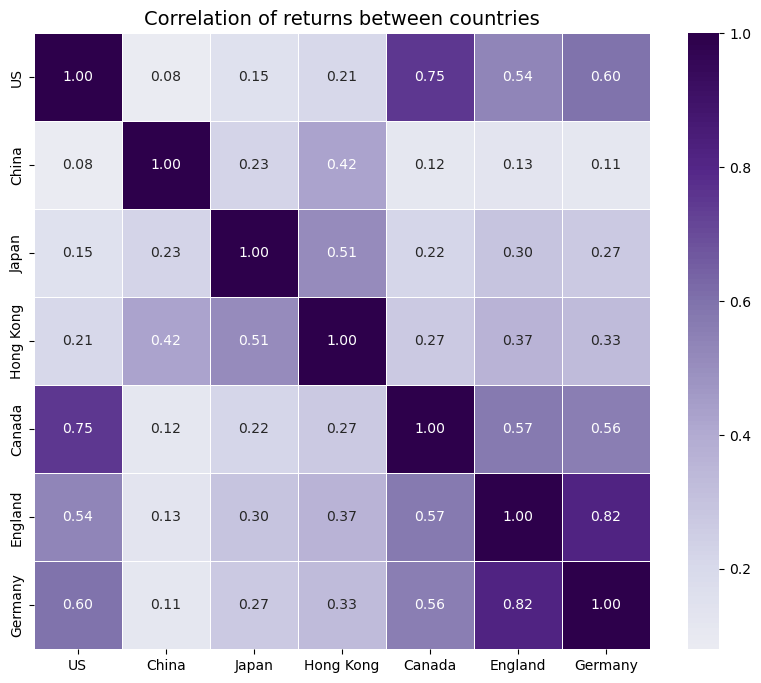

In [135]:


cor_mat = returns.corr()

plt.figure(figsize=(10, 8))  
sns.heatmap(
    cor_mat,               
    annot=True,                   
    fmt=".2f",                    
    cmap="PuOr",              
    center=0,                     
    square=True,                  
    linewidths=0.5,               
)

plt.title("Correlation of returns between countries", fontsize=14)
plt.show()

I calculate the monthly volatility of these indices. I plot the monthly volatilities to show that there is autocorrelation and possible cross auto correlation.

C:\Users\1337m\AppData\Local\Temp\ipykernel_18380\3006591674.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volatility = returns.resample('M').std()


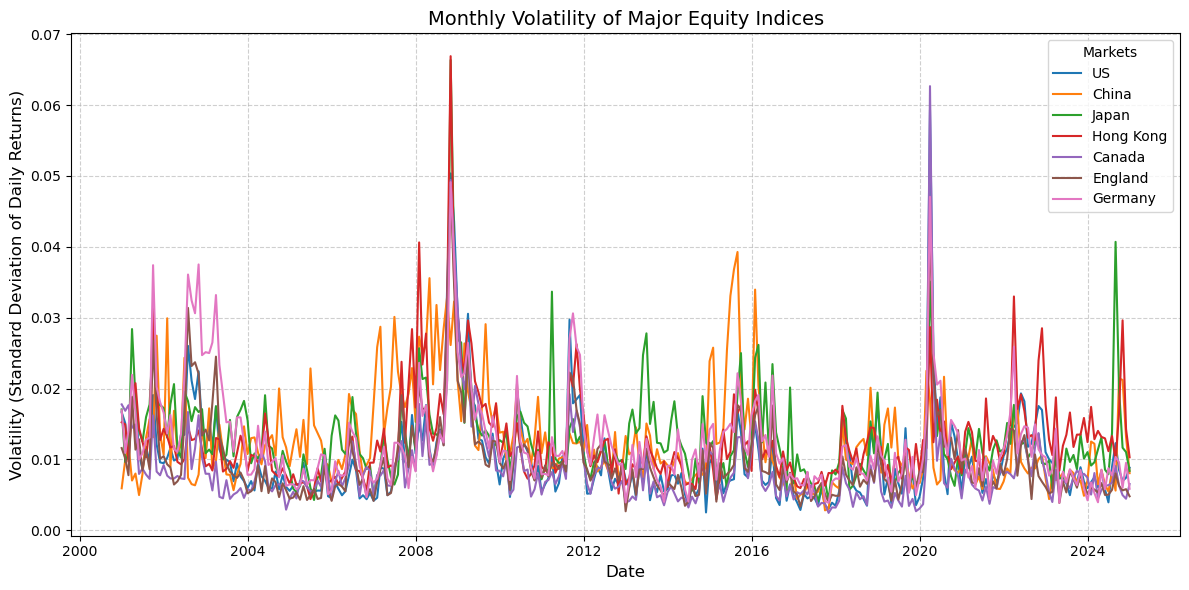

In [136]:
monthly_volatility = returns.resample('M').std()
monthly_volatility.columns = ['US', 'China', 'Japan', 'Hong Kong', 'Canada', 'England', 'Germany']

plt.figure(figsize=(12, 6))  


plt.plot(monthly_volatility)


plt.title("Monthly Volatility of Major Equity Indices", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility (Standard Deviation of Daily Returns)", fontsize=12)


plt.legend(monthly_volatility.columns, title="Markets", fontsize=10)


plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

I create a one lag correlation matrix. Let's refer to this as the spillover correlation matrix.

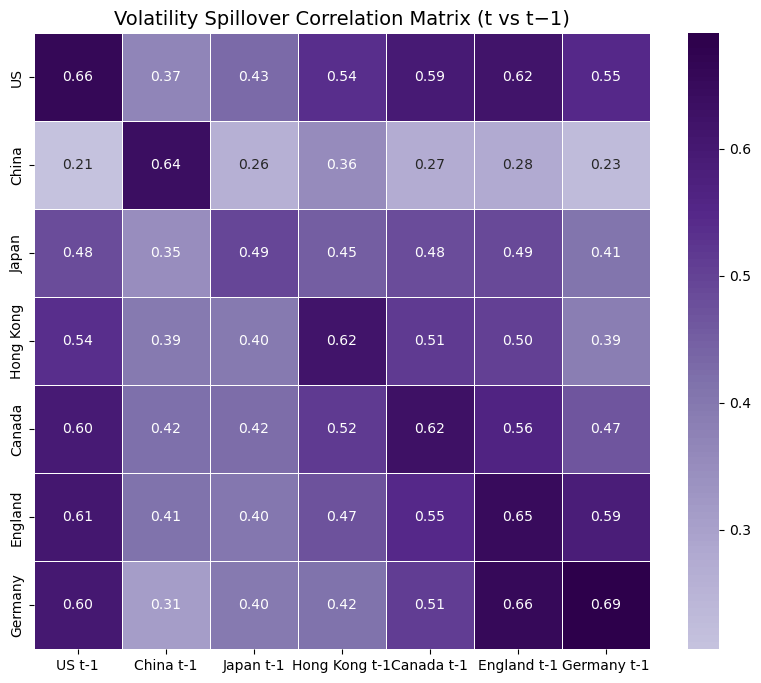

In [137]:
monthly_volatility_t_min = monthly_volatility.shift(1)
monthly_volatility_t_min.columns = ['US t-1', 'China t-1', 'Japan t-1', 'Hong Kong t-1', 'Canada t-1', 'England t-1', 'Germany t-1']

combined_df = pd.concat([monthly_volatility, monthly_volatility_t_min], axis = 1).dropna() 
auto_corr_mat = combined_df.corr()
auto_corr_mat = auto_corr_mat.loc['US': 'Germany','US t-1': 'Germany t-1']




plt.figure(figsize=(10, 8))  
sns.heatmap(
    auto_corr_mat,               
    annot=True,                   
    fmt=".2f",                    
    cmap="PuOr",              
    center=0,                     
    square=True,                  
    linewidths=0.5,               
)

plt.title("Volatility Spillover Correlation Matrix (t vs t−1)", fontsize=14)
plt.show()


### Part 2.  

I will now fit a Vector Auto Regression(VAR) onto the data. To do so I have to determine the hyper parameters of the model. A VAR has two hyper parameters. The first is wich variables to include, i.e. the dimention of output/input. Second, the number of lags the model uses. I will include all the variables, that is to say all the volatilities, into the model as I want to explain the volatility spillover between all of the markets. I will use what is called an information criterion, in this case specifically the Bayesian information criterion, to determine the optimal number of lags.  

The Bayesian information criterion is defined as follows:

$$
\mathrm{BIC} = k \ln(n) - 2 \ln(\hat{L})
$$

Where:

- \( $n$ \): number of observations  
- \( $k$ \): number of estimated parameters in the model  
- \( $\hat{L}$ \): maximized value of the likelihood function  

Think of it as a function that tells you how bad your model is. The smaller the number the better the model is.

In [138]:
model = VAR(np.log(monthly_volatility))
lag_selection = model.select_order(maxlags=10)
print(lag_selection.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.47      -16.38   7.060e-08      -16.43
1       -18.87     -18.14*   6.385e-09     -18.58*
2      -18.89*      -17.52  6.265e-09*      -18.34
3       -18.78      -16.78   6.979e-09      -17.98
4       -18.65      -16.01   7.989e-09      -17.59
5       -18.59      -15.31   8.537e-09      -17.27
6       -18.46      -14.54   9.812e-09      -16.89
7       -18.31      -13.76   1.144e-08      -16.49
8       -18.17      -12.98   1.334e-08      -16.09
9       -18.08      -12.25   1.496e-08      -15.74
10      -17.96      -11.49   1.720e-08      -15.36
--------------------------------------------------


The code outputs a table of information criterions for different lags. The BIC collumn is the Bayesian information criterion. We will select the smallest value i.e. the most negative. It is conveniantly marked with an asterix. 1 lag is the optimal number of lags, wich is convinient for me. Let's move on to fitting the specific VAR model with 1 lag. Notice that I use the log volatility, this is to ensure that we can create predictions of volatilities that are always positive.

In [139]:
lag1_model = model.fit(1)
print(lag1_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 08, Nov, 2025
Time:                     06:50:42
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -18.0612
Nobs:                     288.000    HQIC:                  -18.4880
Log likelihood:          -101.204    FPE:                7.02811e-09
AIC:                     -18.7734    Det(Omega_mle):     5.80155e-09
--------------------------------------------------------------------
Results for equation US
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -1.051410         0.303615           -3.463           0.001
L1.US                0.438978         0.098914            4.438           0.000
L1.China             0.127649         0.053941            2.366    

The output is quite big so let me explain it to you, and also what a Vector Auto Regression actually is. Let's say I have k number of variables. A Vector Auto Regression with l number of lags runs n number of auto regressions for each variable on l lags of all of the k variables, including itself. 



\begin{aligned}
y_{1t} &= c_1 + a_{11}^{(1)} y_{1,t-1} + a_{12}^{(1)} y_{2,t-1} + \dots + a_{1k}^{(1)} y_{k,t-1} \\
&\quad + a_{11}^{(2)} y_{1,t-2} + \dots + a_{1k}^{(l)} y_{k,t-l} + \varepsilon_{1t} \\
\\
y_{2t} &= c_2 + a_{21}^{(1)} y_{1,t-1} + a_{22}^{(1)} y_{2,t-1} + \dots + a_{2k}^{(1)} y_{k,t-1} \\
&\quad + a_{21}^{(2)} y_{1,t-2} + \dots + a_{2k}^{(l)} y_{k,t-l} + \varepsilon_{2t} \\
\\
&\;\;\vdots \\
\\
y_{kt} &= c_k + a_{k1}^{(1)} y_{1,t-1} + a_{k2}^{(1)} y_{2,t-1} + \dots + a_{kk}^{(1)} y_{k,t-1} \\
&\quad + a_{k1}^{(2)} y_{1,t-2} + \dots + a_{kk}^{(l)} y_{k,t-l} + \varepsilon_{kt}
\end{aligned}






The "Vector" part of VAR comes from the representation of this system of equations as  linear transformations, i.e. matrices multiplied with vectors as such.
$$
\mathbf{y}_t = \mathbf{c} + A_1 \mathbf{y}_{t-1} + A_2 \mathbf{y}_{t-2} + \cdots + A_l \mathbf{y}_{t-l} + \boldsymbol{\varepsilon}_t
$$


- $\mathbf{y}_t = 
\begin{bmatrix}
y_{1t} \\
y_{2t} \\
\vdots \\
y_{kt}
\end{bmatrix}$ is a $(k \times 1)$ vector of endogenous variables  

- $\mathbf{c} =
\begin{bmatrix}
c_1 \\
c_2 \\
\vdots \\
c_k
\end{bmatrix}$ is a $(k \times 1)$ vector of intercepts  

- $A_i$ are $(k \times k)$ coefficient matrices  

- $\boldsymbol{\varepsilon}_t =
\begin{bmatrix}
\varepsilon_{1t} \\
\varepsilon_{2t} \\
\vdots \\
\varepsilon_{kt}
\end{bmatrix}$ are innovations with covariance matrix $\Sigma_{\varepsilon}$



Therefore the output gives us the regression results of 7 equations as well as the correlations between the residuals.

To make it easier to interpet these results I will put the coficients in a heat map.


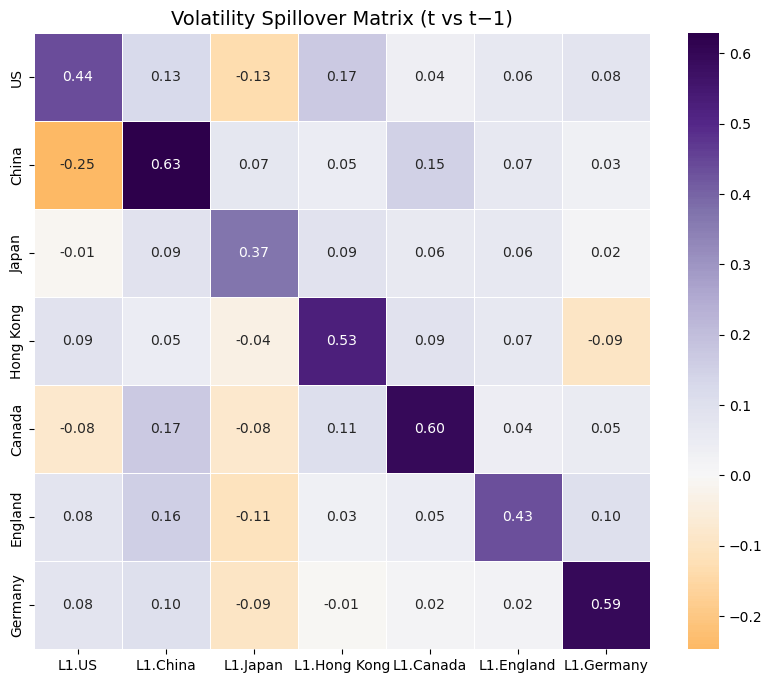

In [140]:
coef_mat = lag1_model.params.iloc[1:,:].T
const = lag1_model.params.iloc[0,:].T
plt.figure(figsize=(10, 8))  
sns.heatmap(
    coef_mat,               
    annot=True,                   
    fmt=".2f",                    
    cmap="PuOr",              
    center=0,                     
    square=True,                  
    linewidths=0.5,               
)

plt.title("Volatility Spillover Matrix (t vs t−1)", fontsize=14)
plt.show()


I use the eigen values to analyse the coefficient matrix. In the context of VARs eigen values are reffered to as roots.

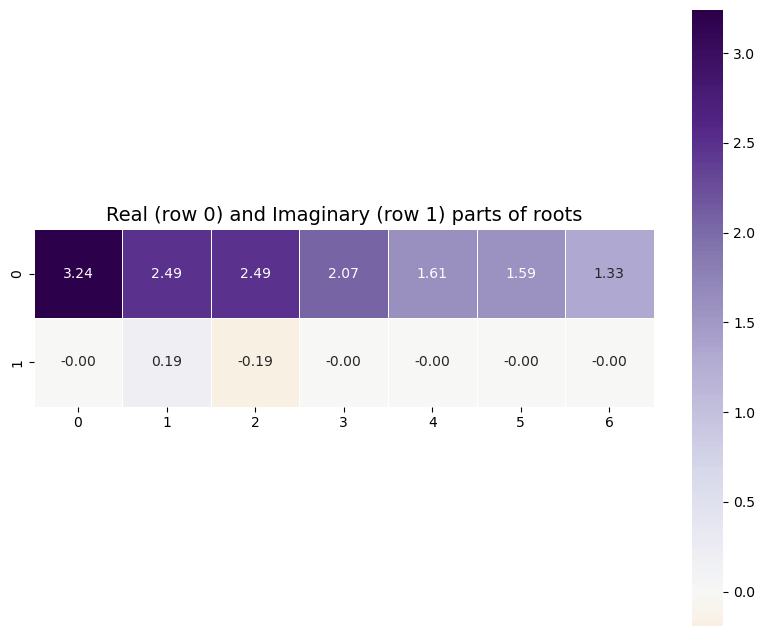

In [141]:
roots = lag1_model.roots
roots_array = np.array([roots.real, roots.imag])
plt.figure(figsize=(10, 8))  
sns.heatmap(
    roots_array,               
    annot=True,                   
    fmt=".2f",                    
    cmap="PuOr",              
    center=0,                     
    square=True,                  
    linewidths=0.5,               
)

plt.title("Real (row 0) and Imaginary (row 1) parts of roots", fontsize=14)
plt.show()


The wat eigen values are interpreted in the context of a var is that when $ \lambda = 1 $ the process is stable and it settles on an equilibrium. If $ \lambda \gt 1$ then it is unstable and the process will grow forever. If $ \lambda \lt 1$. If we look at the eigen values we see that the process is not stationary, that is to say kind of explodes, but we also see that the eigen values are complex wich makes the process cyclical, i.e. it goes back and forth between exploding and not exploding. This fits the theoretical assumptions about volatility.

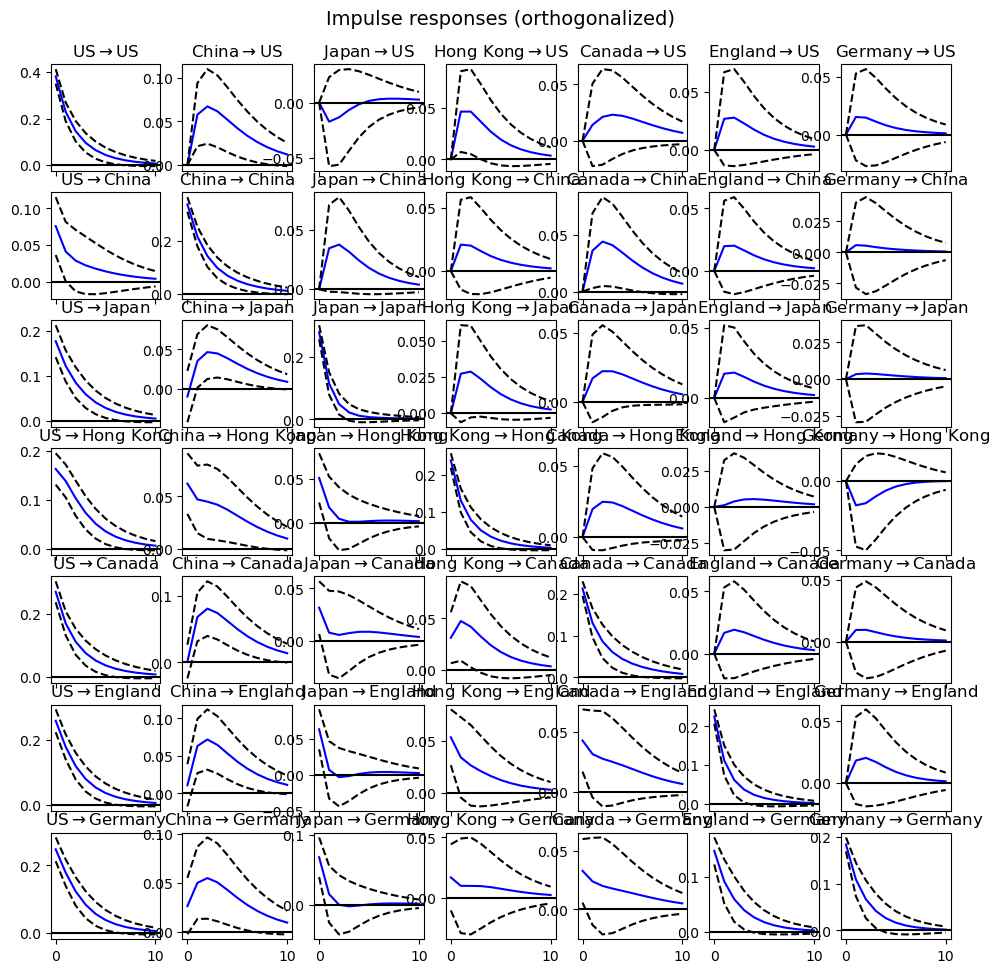

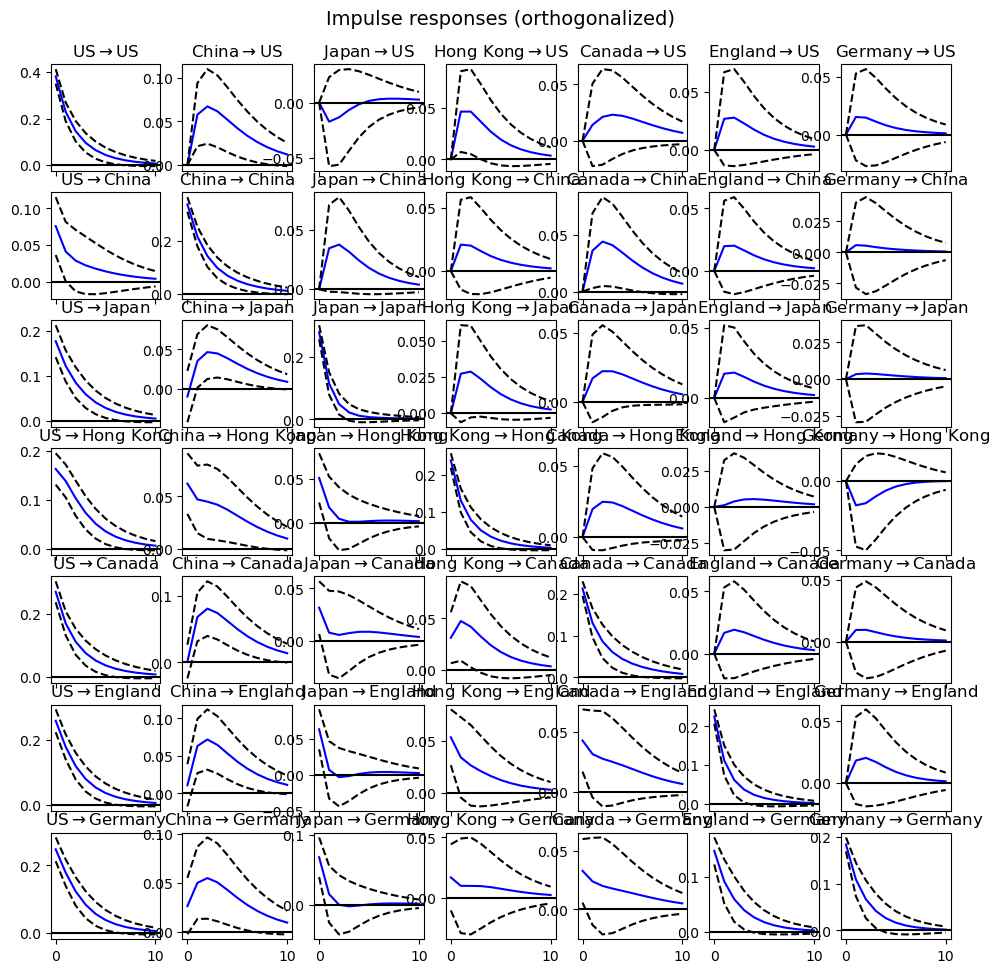

In [142]:
lag1_model.irf(10).plot(orth = True)

I continue to simulate the log volatility spillover using the VAR coeficients and the variance and covariance matrix of the residuals. First I draw random variables using the variance covariance matrix of the residuals. Then I simulate the data stepwise through a loop.



In [143]:
Sigma_e = lag1_model.sigma_u


k = Sigma_e.shape[0]   # number of variables
T = 24*12             # number of shocks to generate

# Mean vector = 0 for shocks
mu = np.zeros(k)

# Sample T shocks
shocks = np.random.multivariate_normal(mean=mu, cov=Sigma_e, size=T)


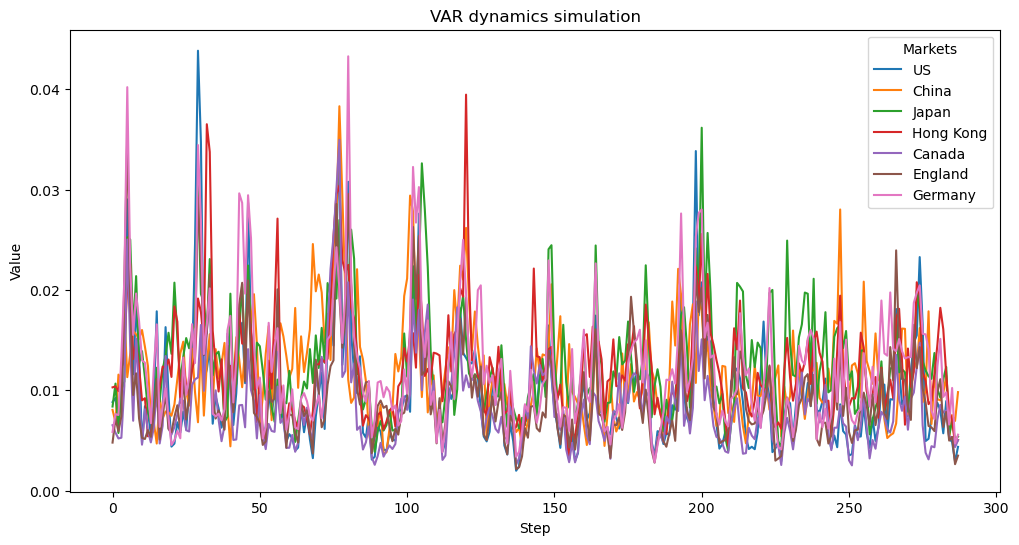

In [144]:
sim = np.zeros((T, k))
y0 = np.log(monthly_volatility.iloc[-1,:])

sim[0] = y0

for t in range(1, T):
    sim[t] = coef_mat @ sim[t-1] + shocks[t] + const


plt.figure(figsize=(12, 6))  
for i in range(7):
    plt.plot(np.exp(sim[:, i]), label=f'Var {i+1}')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('VAR dynamics simulation')
plt.legend(monthly_volatility.columns, title="Markets", fontsize=10)
plt.show();

We can see that the simulation looks very similar to the data.

In [145]:
tscv = TimeSeriesSplit(n_splits=5)

lags = [1,2,3,4]
results = [0,0,0,0,0]

for p in lags:
    fold_mse = []
    
    # Iterate through the time series folds
    for train_idx, test_idx in tscv.split(monthly_volatility):
        train, test = monthly_volatility.iloc[train_idx], monthly_volatility.iloc[test_idx]

        # Fit VAR on training data
        model = VAR(np.log(train))
        fitted = model.fit(maxlags=p)

        # Forecast same length as test
        lag_order = fitted.k_ar
        forecast_input = train.values[-lag_order:]

        # Forecast log-volatility
        forecast_log = np.array(fitted.forecast(y=forecast_input, steps=len(test)))

        # Bias-corrected volatility forecast
        sigma2 = np.var(fitted.resid.values, axis=0)
        forecast = np.exp(forecast_log + 0.5 * sigma2[None, :])

        # Convert to DataFrame (correct orientation)
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)


        
        # Compute mean squared error across all variables
        mse = np.mean((test - forecast_df)**2)
        fold_mse.append(mse)

    # Average across folds
    results[p] = np.mean(fold_mse)
    print(f"Lag {p}: Average MSE = {results[p]:.6f}")

Lag 1: Average MSE = 0.004362
Lag 2: Average MSE = 0.006830
Lag 3: Average MSE = 0.016255
Lag 4: Average MSE = 7.652323


Notice that the forecast includes the variances of the residuals, this is due to the fact that,

$$
\mathbb{E}[e^x] \neq e^{\mathbb{E}[x]} 
$$

Instead we use the moment generating function of a log normal random variable and ger,


$$
\mathbb{E}[e^x] = e^{\mathbb{E}[x] + 0.5 \cdot \mathbb{Var}(x)}
$$

Since I am predicting the log volatility.

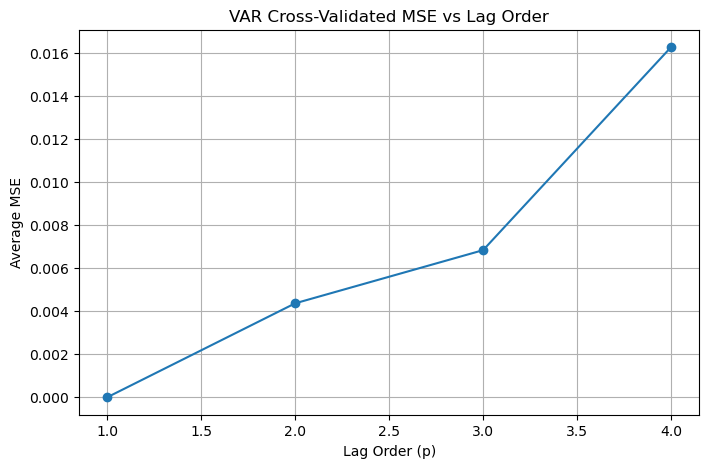

In [146]:
plt.figure(figsize=(8,5))
plt.plot(lags,results[:-1], marker='o')  # ensure correct values
plt.xlabel("Lag Order (p)")
plt.ylabel("Average MSE")
plt.title("VAR Cross-Validated MSE vs Lag Order")
plt.grid(True)
plt.show()

In [147]:
# Hyperparameter grid
layer_sizes = [16, 32, 64]        # number of units per hidden layer
num_layers = [1, 2, 3]            # number of hidden layers

results_fnn = {}
data = monthly_volatility.to_numpy()
# Grid search
for layers in num_layers:
    for units in layer_sizes:
        fold_mse = []

        for train_idx, test_idx in tscv.split(data):
            X_train, X_test = data[train_idx], data[test_idx]
            y_train, y_test = X_train.copy(), X_test.copy()  # next-step prediction

            # Build model
            model = keras.Sequential()
            # Add hidden layers
            for _ in range(layers):
                model.add(keras.layers.Dense(units, activation='relu', input_shape=(n_features,)))
            # Output layer
            model.add(keras.layers.Dense(n_features))

            model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                          loss='mse')

            model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

            y_pred = model.predict(X_test, verbose=0)
            mse = np.mean((y_test - y_pred)**2)
            fold_mse.append(mse)

        # Average over folds
        results_fnn[(layers, units)] = np.mean(fold_mse)
        print(f"Layers: {layers}, Units: {units} -> Average MSE: {results_fnn[(layers, units)]:.6f}")

c:\Users\1337m\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Layers: 1, Units: 16 -> Average MSE: 0.000015
Layers: 1, Units: 32 -> Average MSE: 0.000015
Layers: 1, Units: 64 -> Average MSE: 0.000007
Layers: 2, Units: 16 -> Average MSE: 0.000014
Layers: 2, Units: 32 -> Average MSE: 0.000008
Layers: 2, Units: 64 -> Average MSE: 0.000006
Layers: 3, Units: 16 -> Average MSE: 0.000012
Layers: 3, Units: 32 -> Average MSE: 0.000011
Layers: 3, Units: 64 -> Average MSE: 0.000005


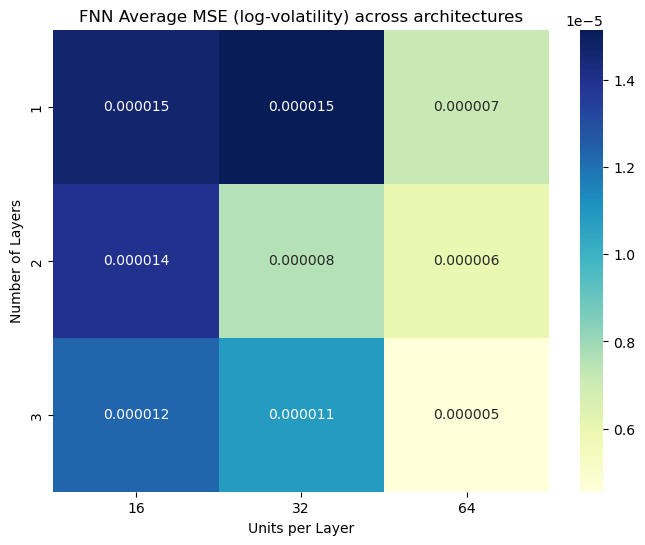

In [148]:
# Convert results to DataFrame
df_results = pd.DataFrame(
    index=num_layers,
    columns=layer_sizes,
    data=[[results_fnn[(l, u)] for u in layer_sizes] for l in num_layers]
)

plt.figure(figsize=(8,6))
sns.heatmap(df_results, annot=True, fmt=".6f", cmap="YlGnBu")
plt.xlabel("Units per Layer")
plt.ylabel("Number of Layers")
plt.title("FNN Average MSE (log-volatility) across architectures")
plt.show()


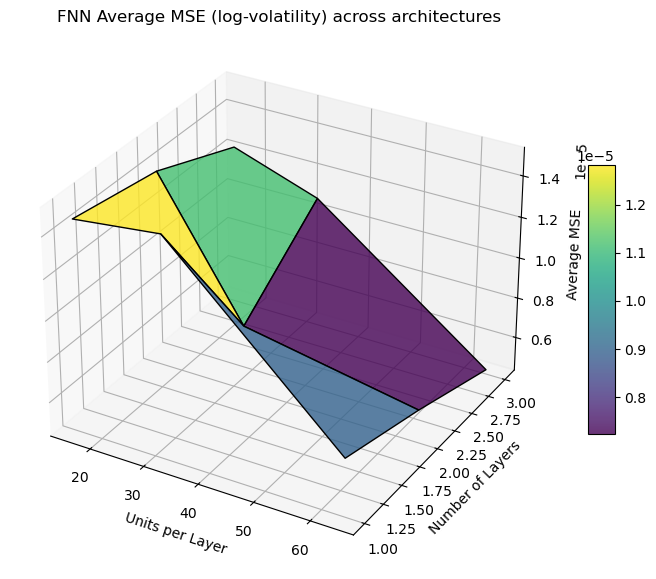

In [149]:
# Prepare data
X, Y = np.meshgrid(layer_sizes, num_layers)  # units on x-axis, layers on y-axis
Z = np.array([[results_fnn[(l, u)] for u in layer_sizes] for l in num_layers])  # MSE

# Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

# Add labels
ax.set_xlabel("Units per Layer")
ax.set_ylabel("Number of Layers")
ax.set_zlabel("Average MSE")
ax.set_title("FNN Average MSE (log-volatility) across architectures")

# Color bar
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


In [150]:
split = 2/3
length = monthly_volatility.shape[0]
data_train = monthly_volatility.iloc[:int(length*split), :]
data_test = monthly_volatility.iloc[int(length*split):, :]

In [151]:
test_VAR = VAR(np.log(data_train))
optimal_lag = test_VAR.select_order(maxlags=10).summary()
test_VAR = test_VAR.fit(1)
print(test_VAR.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 08, Nov, 2025
Time:                     06:53:42
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -18.3147
Nobs:                     191.000    HQIC:                  -18.8820
Log likelihood:          -1.00283    FPE:                4.28602e-09
AIC:                     -19.2683    Det(Omega_mle):     3.21600e-09
--------------------------------------------------------------------
Results for equation US
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -1.215211         0.370157           -3.283           0.001
L1.US                0.444405         0.127024            3.499           0.000
L1.China             0.112911         0.069313            1.629    

In [152]:
print(optimal_lag)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.23      -17.11   3.281e-08      -17.18
1      -19.43*     -18.44*  3.651e-09*     -19.03*
2       -19.28      -17.43   4.264e-09      -18.53
3       -19.15      -16.44   4.848e-09      -18.05
4       -18.93      -15.36   6.098e-09      -17.49
5       -18.75      -14.31   7.480e-09      -16.95
6       -18.54      -13.25   9.421e-09      -16.40
7       -18.31      -12.15   1.238e-08      -15.81
8       -18.15      -11.13   1.528e-08      -15.30
9       -17.95      -10.06   1.998e-08      -14.75
10      -17.89      -9.140   2.309e-08      -14.34
--------------------------------------------------


In [153]:
forecast_input = data_train.values[-1:].copy()
predictions = []

# Step-by-step forecasting for test period
for i in range(len(data_test)):
    # Forecast 1 step ahead
    y_pred = test_VAR.forecast(y= np.log(forecast_input), steps=1)
    predictions.append(y_pred[0])
    
    # Update forecast input: drop oldest, add actual from test set
    forecast_input = np.vstack([forecast_input[1:], data_test.values[i]])

# Convert predictions to DataFrame
pred_df = pd.DataFrame(predictions, index=data_test.index, columns=data_test.columns)

sigma2 = test_VAR.resid.var(axis=0)

# Compute MSE per variable
mse_VAR = ((np.exp(pred_df + 0.5 * sigma2) - data_test) ** 2).mean()
mse_VAR

US           0.000033
China        0.000021
Japan        0.000024
Hong Kong    0.000023
Canada       0.000034
England      0.000018
Germany      0.000025
dtype: float64

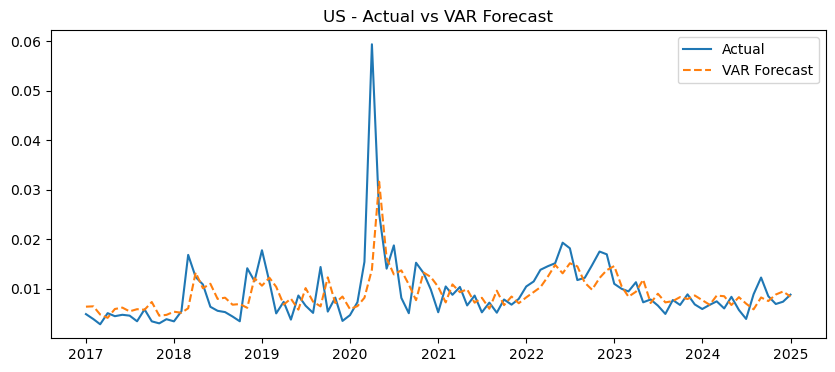

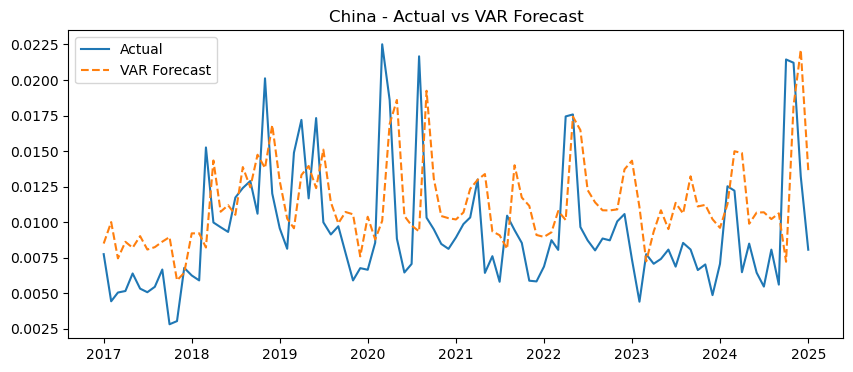

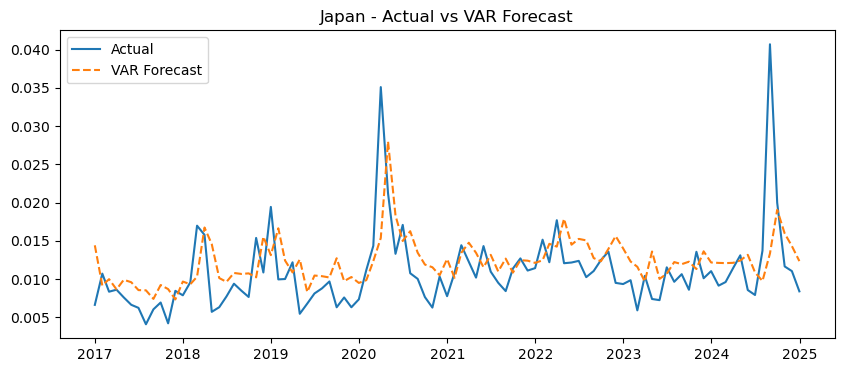

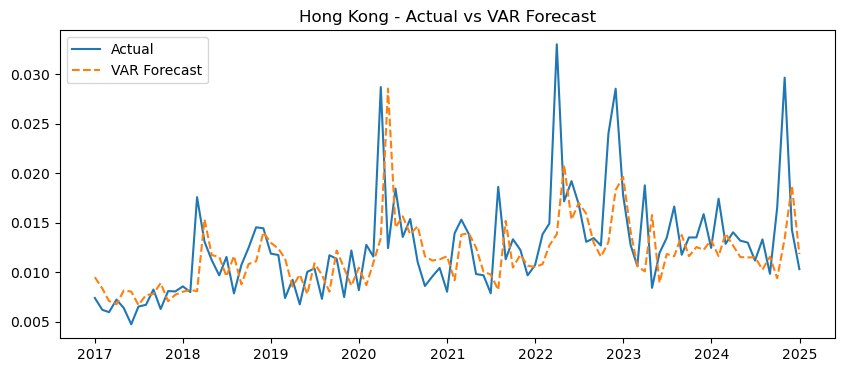

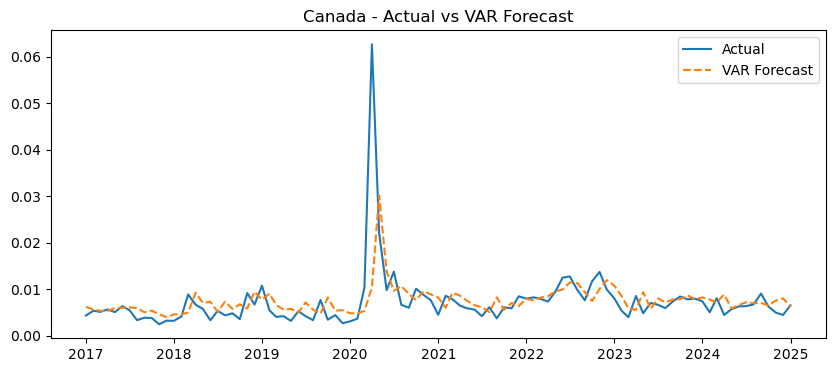

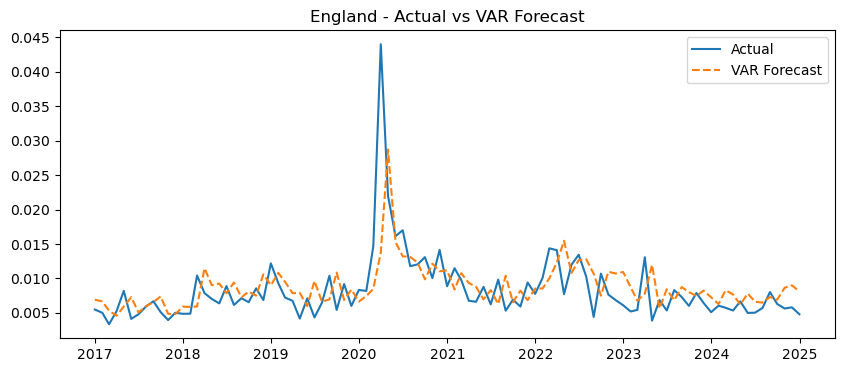

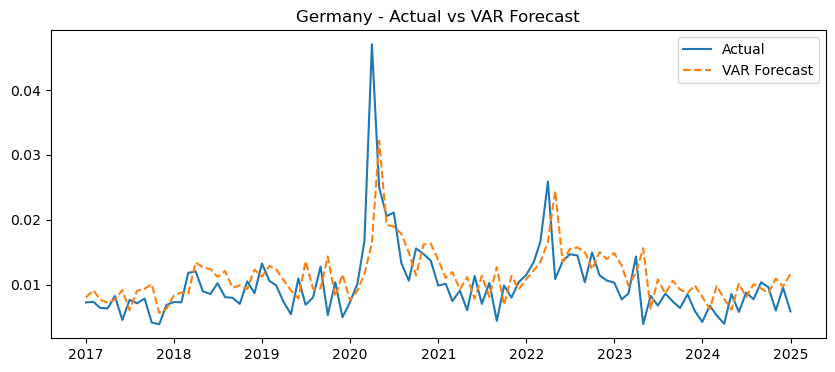

In [154]:
for col in data_test.columns:
    plt.figure(figsize=(10,4))
    plt.plot(data_test[col], label='Actual')
    plt.plot(np.exp(pred_df[col] + 0.5 * sigma2[col]), label='VAR Forecast', linestyle='--')
    plt.title(f"{col} - Actual vs VAR Forecast")
    plt.legend()
    plt.show()

In [155]:
def create_lagged_data(df, lags=1):
    X, y = [], []
    for t in range(lags, len(df)):
        X.append(df.values[t-lags:t].flatten())   
        y.append(df.values[t])                    
    return np.array(X), np.array(y)

lags = 1 # number of past periods to use as input
X_train, y_train = create_lagged_data(data_train, lags)
X_test, y_test = create_lagged_data(data_test, lags)


In [156]:
n_features = X_train.shape[1]   # lags * variables
n_outputs = y_train.shape[1]    # number of variables to predict

model = Sequential([
    Dense(64, activation='relu', input_shape=(n_features,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_outputs)  
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()


c:\Users\1337m\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_380 (Dense)               │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,287 (36.28 KB)

 Trainable params: 9,287 (36.28 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0979e-05 - val_loss: 3.2878e-05
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5725e-05 - val_loss: 2.7967e-05
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1551e-05 - val_loss: 2.9598e-05
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9964e-05 - val_loss: 3.0593e-05
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8707e-05 - val_loss: 3.0923e-05
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7896e-05 - val_loss: 2.8328e-05
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7234e-05 - val_loss: 2.8162e-05
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6288e-05 - val_loss: 2.8738e-05
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5387e-05 - val_loss: 3.1587e-05
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6219e-05 - val_loss: 2.9884e-05
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5537e-

In [158]:
# Convert to DataFrame for easier comparison
y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, index=data_test.index[lags:], columns=data_test.columns)
y_true_df = pd.DataFrame(y_test, index=data_test.index[lags:], columns=data_test.columns)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [159]:
mse_FNN = ((y_pred_df - y_true_df) ** 2).mean()
mse_FNN

US           0.000046
China        0.000027
Japan        0.000030
Hong Kong    0.000040
Canada       0.000038
England      0.000022
Germany      0.000025
dtype: float64

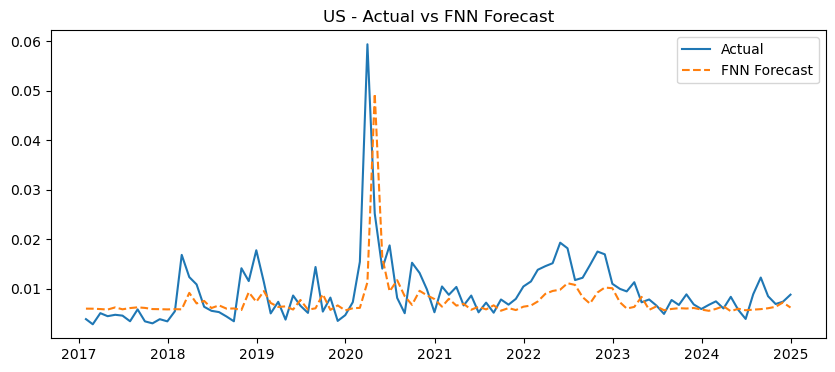

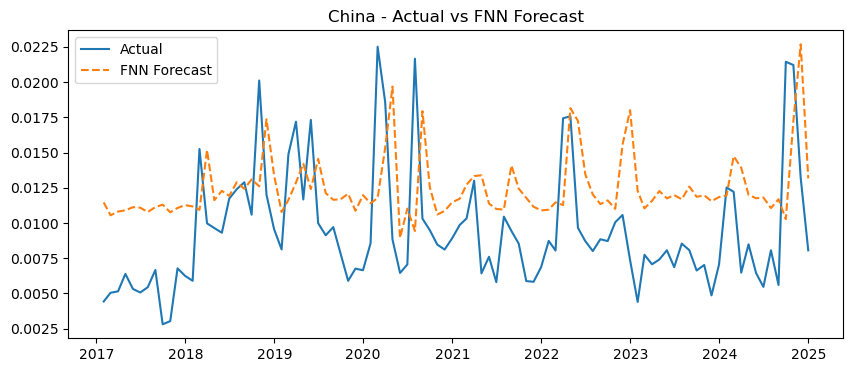

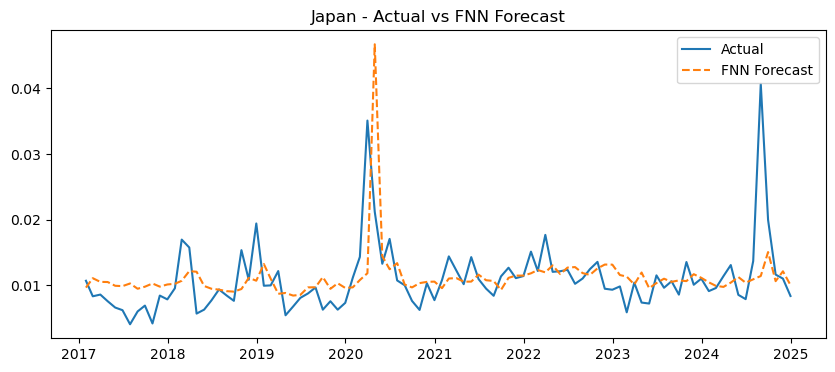

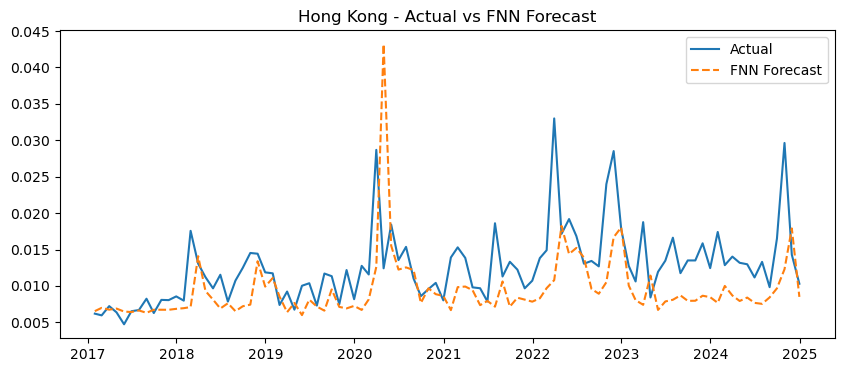

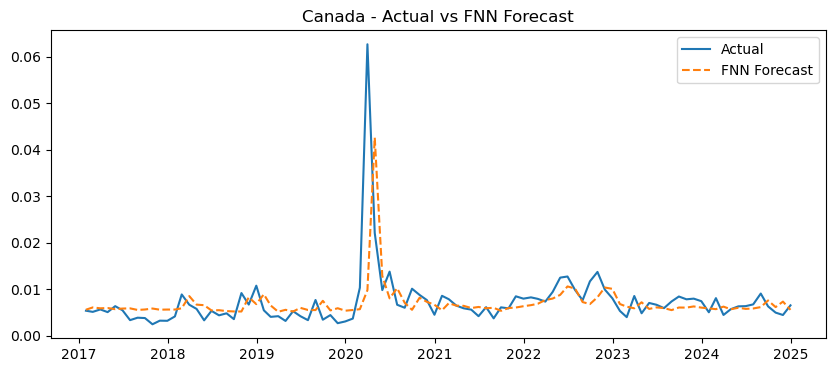

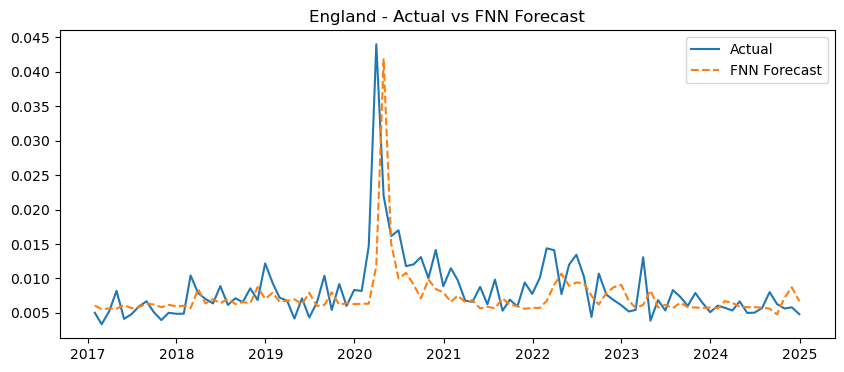

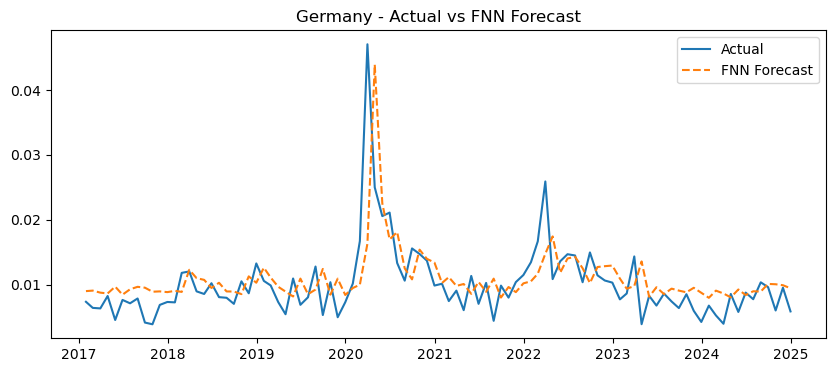

In [160]:
for col in data_test.columns:
    plt.figure(figsize=(10,4))
    plt.plot(y_true_df[col], label='Actual')
    plt.plot(y_pred_df[col], label='FNN Forecast', linestyle='--')
    plt.title(f"{col} - Actual vs FNN Forecast")
    plt.legend()
    plt.show()

In [161]:
mse_FNN - mse_VAR

US           1.230978e-05
China        6.302227e-06
Japan        5.520383e-06
Hong Kong    1.736540e-05
Canada       4.184709e-06
England      4.605021e-06
Germany     -2.912989e-07
dtype: float64

We can see that the VAR outperforms the FNN. That is to say that making theoretical asumptions about data can drastically reduce the number of required parameters and estimation time.